📊 Teste de Friedman: χ² = 20.5000, p = 0.0001
✅ Diferença estatisticamente significativa encontrada. Executando Nemenyi...

🔍 Matriz de p-valores (Nemenyi):
          KNN        DT        NB       MLP
KNN  1.000000  0.036176  0.989058  0.303273
DT   0.036176  1.000000  0.014172  0.000056
NB   0.989058  0.014172  1.000000  0.484854
MLP  0.303273  0.000056  0.484854  1.000000


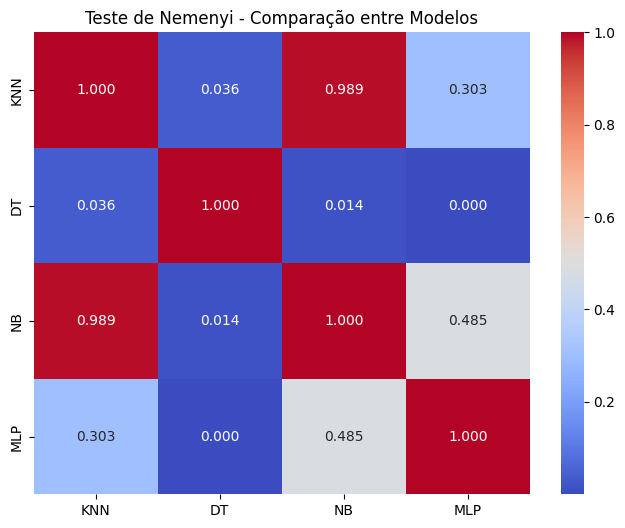


Rankings por dataset:
    KNN   DT   NB  MLP
0   3.0  4.0  2.0  1.0
1   3.0  4.0  2.0  1.0
2   3.0  4.0  1.0  2.0
3   3.0  4.0  1.0  2.0
4   2.0  4.0  3.0  1.0
5   2.0  4.0  3.0  1.0
6   2.0  3.0  4.0  1.0
7   1.0  3.0  4.0  2.0
8   3.0  4.0  1.0  2.0
9   3.0  4.0  2.0  1.0
10  2.0  4.0  1.0  3.0
11  2.0  4.0  3.0  1.0

Ranking médio dos métodos:
MLP    1.500000
NB     2.250000
KNN    2.416667
DT     3.833333
dtype: float64

Critical Difference (CD) para α=0.05: 1.2349


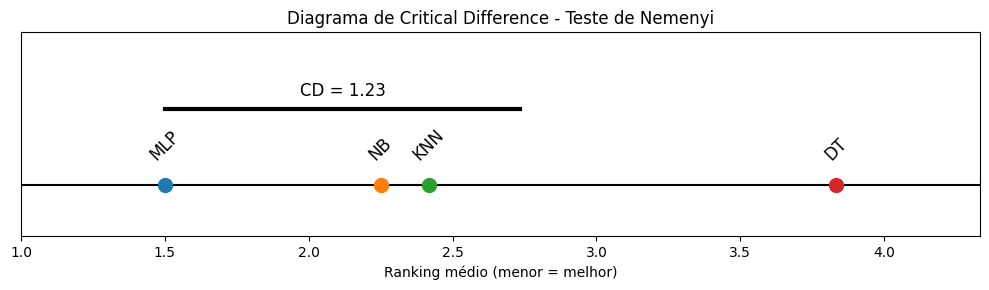

In [ ]:
import pandas as pd
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt

# ⚠️ Substitua pelo caminho correto se necessário
arquivo = 'RESULTADOS_TESTES.csv'

# 1. Ler o CSV, pulando as linhas vazias e cabeçalhos intermediários
df = pd.read_csv(arquivo, skip_blank_lines=True)

# 2. Limpar colunas vazias e renomear
df.columns = ['BASES', 'TREINO_TESTE', 'KNN', 'DT', 'NB', 'MLP']
df = df.dropna(subset=['TREINO_TESTE'])  # remove linhas vazias

# 3. Filtrar apenas linhas de 10-fold CV
df_cv = df[df['TREINO_TESTE'].str.contains('10-fold', case=False)]

# 4. Selecionar colunas dos modelos
dados_testes = df_cv[['KNN', 'DT', 'NB', 'MLP']].astype(float).reset_index(drop=True)

# 5. Aplicar teste de Friedman
friedman_stat, p_value = friedmanchisquare(*[dados_testes[col] for col in dados_testes.columns])
print(f"📊 Teste de Friedman: χ² = {friedman_stat:.4f}, p = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Diferença estatisticamente significativa encontrada. Executando Nemenyi...")
    nemenyi = sp.posthoc_nemenyi_friedman(dados_testes)

    print("\n🔍 Matriz de p-valores (Nemenyi):")
    print(nemenyi)

    # Heatmap da matriz Nemenyi
    plt.figure(figsize=(8, 6))
    sns.heatmap(nemenyi, annot=True, cmap="coolwarm", fmt=".3f")
    plt.title("Teste de Nemenyi - Comparação entre Modelos")
    plt.show()
else:
    print("⚠️ Não há diferença estatisticamente significativa entre os modelos.")

# 6. Calcular rankings (maior valor = melhor ranking = 1)
def rank_row(row):
    return row.rank(ascending=False, method='average')

rankings = dados_testes.apply(rank_row, axis=1)

print("\nRankings por dataset:")
print(rankings)

# Calcular média dos rankings
mean_ranks = rankings.mean().sort_values()
print("\nRanking médio dos métodos:")
print(mean_ranks)

# --- Código para calcular o Critical Difference (CD) e plotar o gráfico sem Orange ---

k = len(mean_ranks)     # número de métodos
N = rankings.shape[0]   # número de datasets

# Valores críticos q_alpha para o teste de Nemenyi (para diferentes níveis de significância)
q_alpha = {
    0.10: 1.960,
    0.05: 2.343,
    0.01: 2.807
}

alpha = 0.05
q = q_alpha[alpha]

# Fórmula do CD do teste Nemenyi
cd = q * sqrt(k*(k+1) / (6*N))

print(f"\nCritical Difference (CD) para α={alpha}: {cd:.4f}")

# Ordenar os métodos para plotagem (menor ranking = melhor)
sorted_idx = np.argsort(mean_ranks.values)
sorted_ranks = mean_ranks.values[sorted_idx]
sorted_names = mean_ranks.index[sorted_idx]

plt.figure(figsize=(10, 3))
plt.title("Diagrama de Critical Difference - Teste de Nemenyi")

# Linha base horizontal
plt.hlines(1, xmin=sorted_ranks.min() - 0.5, xmax=sorted_ranks.max() + 0.5, color='black')

# Plotar pontos dos rankings médios
for i, (rank, name) in enumerate(zip(sorted_ranks, sorted_names)):
    plt.plot(rank, 1, 'o', markersize=10)
    plt.text(rank, 1.1, name, rotation=45, ha='center', fontsize=12)

# Desenhar o CD como uma barra acima dos pontos
plt.plot([sorted_ranks.min(), sorted_ranks.min() + cd], [1.3, 1.3], color='black', lw=3)
plt.text(sorted_ranks.min() + cd/2, 1.35, f'CD = {cd:.2f}', ha='center', fontsize=12)

plt.yticks([])
plt.xlabel("Ranking médio (menor = melhor)")
plt.xlim(sorted_ranks.min() - 0.5, sorted_ranks.max() + 0.5)
plt.ylim(0.8, 1.6)
plt.tight_layout()
plt.show()
